In [1]:
# Add these new libraries
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest, f_classif, chi2
from imblearn.over_sampling import ADASYN # Crucial for Class Balancing
from sklearn.preprocessing import MinMaxScaler # Needed for Chi-Square
import lightgbm as lgb # Recommended by the "Accurate..." paper

In [2]:
import pandas as pd

df = pd.read_csv('/content/drive/MyDrive/Heart.csv')

print("First few rows of the DataFrame:")
display(df.head())

print("\nInformation about the DataFrame:")
display(df.info())

First few rows of the DataFrame:


,Unnamed: 0,Age,Sex,ChestPain,RestBP,Chol,Fbs,RestECG,MaxHR,ExAng,Oldpeak,Slope,Ca,Thal,AHD
0,1,63,1,typical,145,233,1,2,150,0,2.3,3,0.0,fixed,No
1,2,67,1,asymptomatic,160,286,0,2,108,1,1.5,2,3.0,normal,Yes
2,3,67,1,asymptomatic,120,229,0,2,129,1,2.6,2,2.0,reversable,Yes
3,4,37,1,nonanginal,130,250,0,0,187,0,3.5,3,0.0,normal,No
4,5,41,0,nontypical,130,204,0,2,172,0,1.4,1,0.0,normal,No



Information about the DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  303 non-null    int64  
 1   Age         303 non-null    int64  
 2   Sex         303 non-null    int64  
 3   ChestPain   303 non-null    object 
 4   RestBP      303 non-null    int64  
 5   Chol        303 non-null    int64  
 6   Fbs         303 non-null    int64  
 7   RestECG     303 non-null    int64  
 8   MaxHR       303 non-null    int64  
 9   ExAng       303 non-null    int64  
 10  Oldpeak     303 non-null    float64
 11  Slope       303 non-null    int64  
 12  Ca          299 non-null    float64
 13  Thal        301 non-null    object 
 14  AHD         303 non-null    object 
dtypes: float64(2), int64(10), object(3)
memory usage: 35.6+ KB


None

In [3]:
print("Missing values in each column:")
display(df.isnull().sum())

print("\nDescriptive statistics for numerical columns:")
display(df.describe())

print("\nDistribution of the target variable 'AHD':")
display(df['AHD'].value_counts())

Missing values in each column:


,0
Unnamed: 0,0
Age,0
Sex,0
ChestPain,0
RestBP,0
Chol,0
Fbs,0
RestECG,0
MaxHR,0
ExAng,0



Descriptive statistics for numerical columns:


,Unnamed: 0,Age,Sex,RestBP,Chol,Fbs,RestECG,MaxHR,ExAng,Oldpeak,Slope,Ca
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,299.000000
mean,152.000000,54.438944,0.679868,131.689769,246.693069,0.148515,0.990099,149.607261,0.326733,1.039604,1.600660,0.672241
std,87.612784,9.038662,0.467299,17.599748,51.776918,0.356198,0.994971,22.875003,0.469794,1.161075,0.616226,0.937438
min,1.000000,29.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,1.000000,0.000000
25%,76.500000,48.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000
50%,152.000000,56.000000,1.000000,130.000000,241.000000,0.000000,1.000000,153.000000,0.000000,0.800000,2.000000,0.000000
75%,227.500000,61.000000,1.000000,140.000000,275.000000,0.000000,2.000000,166.000000,1.000000,1.600000,2.000000,1.000000
max,303.000000,77.000000,1.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,3.000000,3.000000



Distribution of the target variable 'AHD':


,count
AHD,
No,164
Yes,139


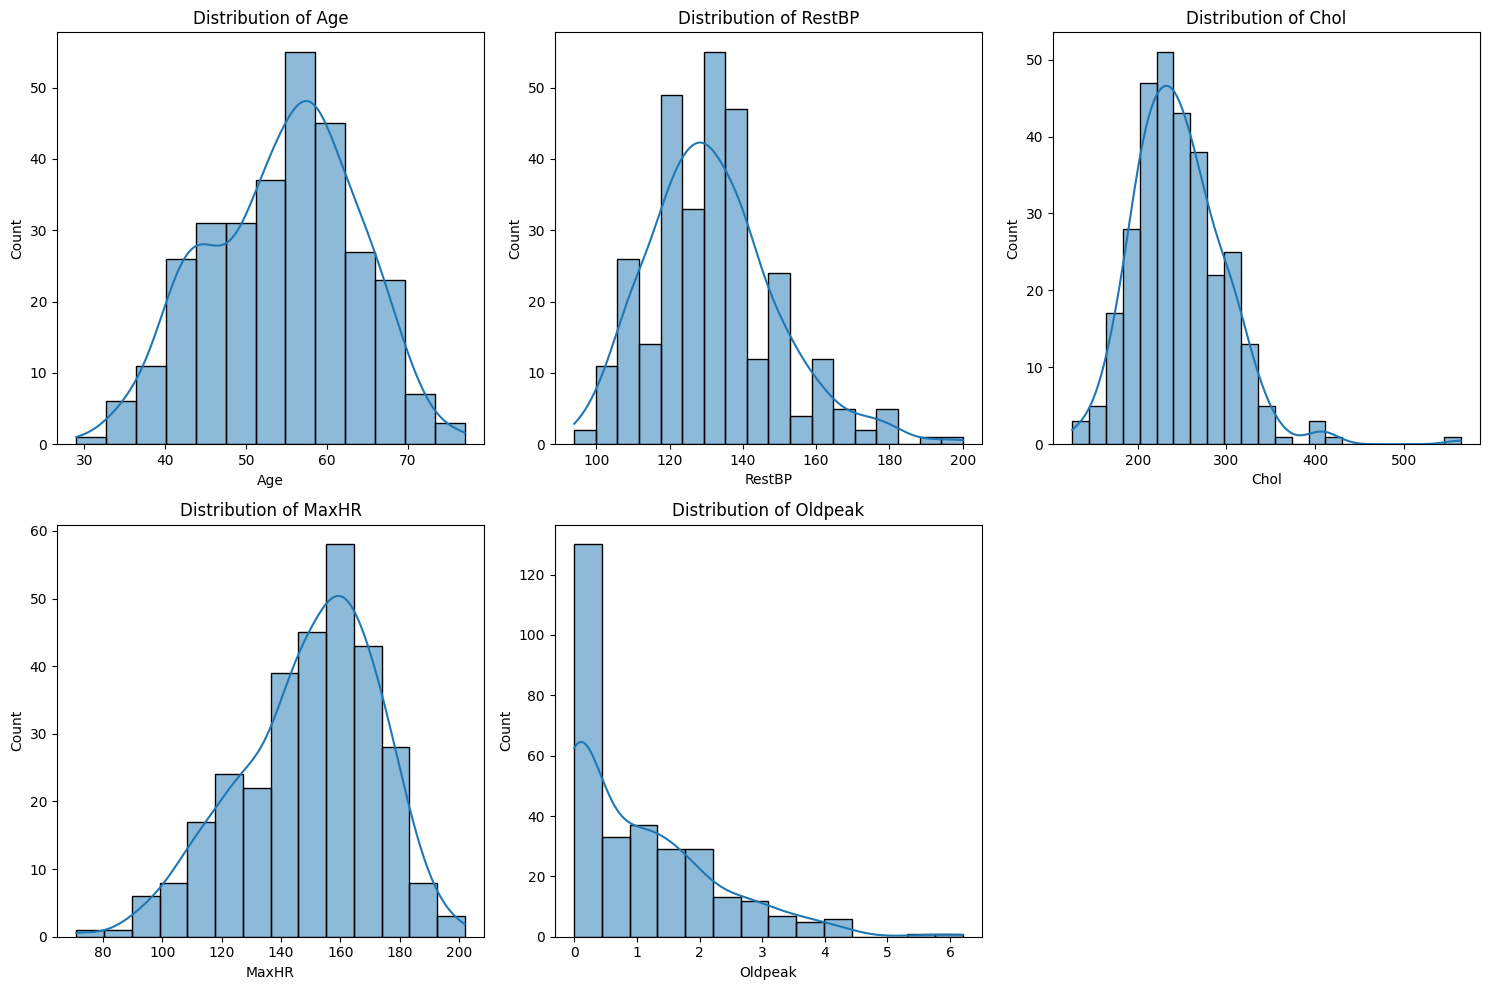

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

numerical_features = ['Age', 'RestBP', 'Chol', 'MaxHR', 'Oldpeak']
categorical_features = ['Sex', 'ChestPain', 'Fbs', 'RestECG', 'ExAng', 'Slope', 'Ca', 'Thal']

# Histograms for numerical features
plt.figure(figsize=(15, 10))
for i, feature in enumerate(numerical_features):
    plt.subplot(2, 3, i + 1)
    sns.histplot(df[feature], kde=True)
    plt.title(f'Distribution of {feature}')
plt.tight_layout()
plt.show()



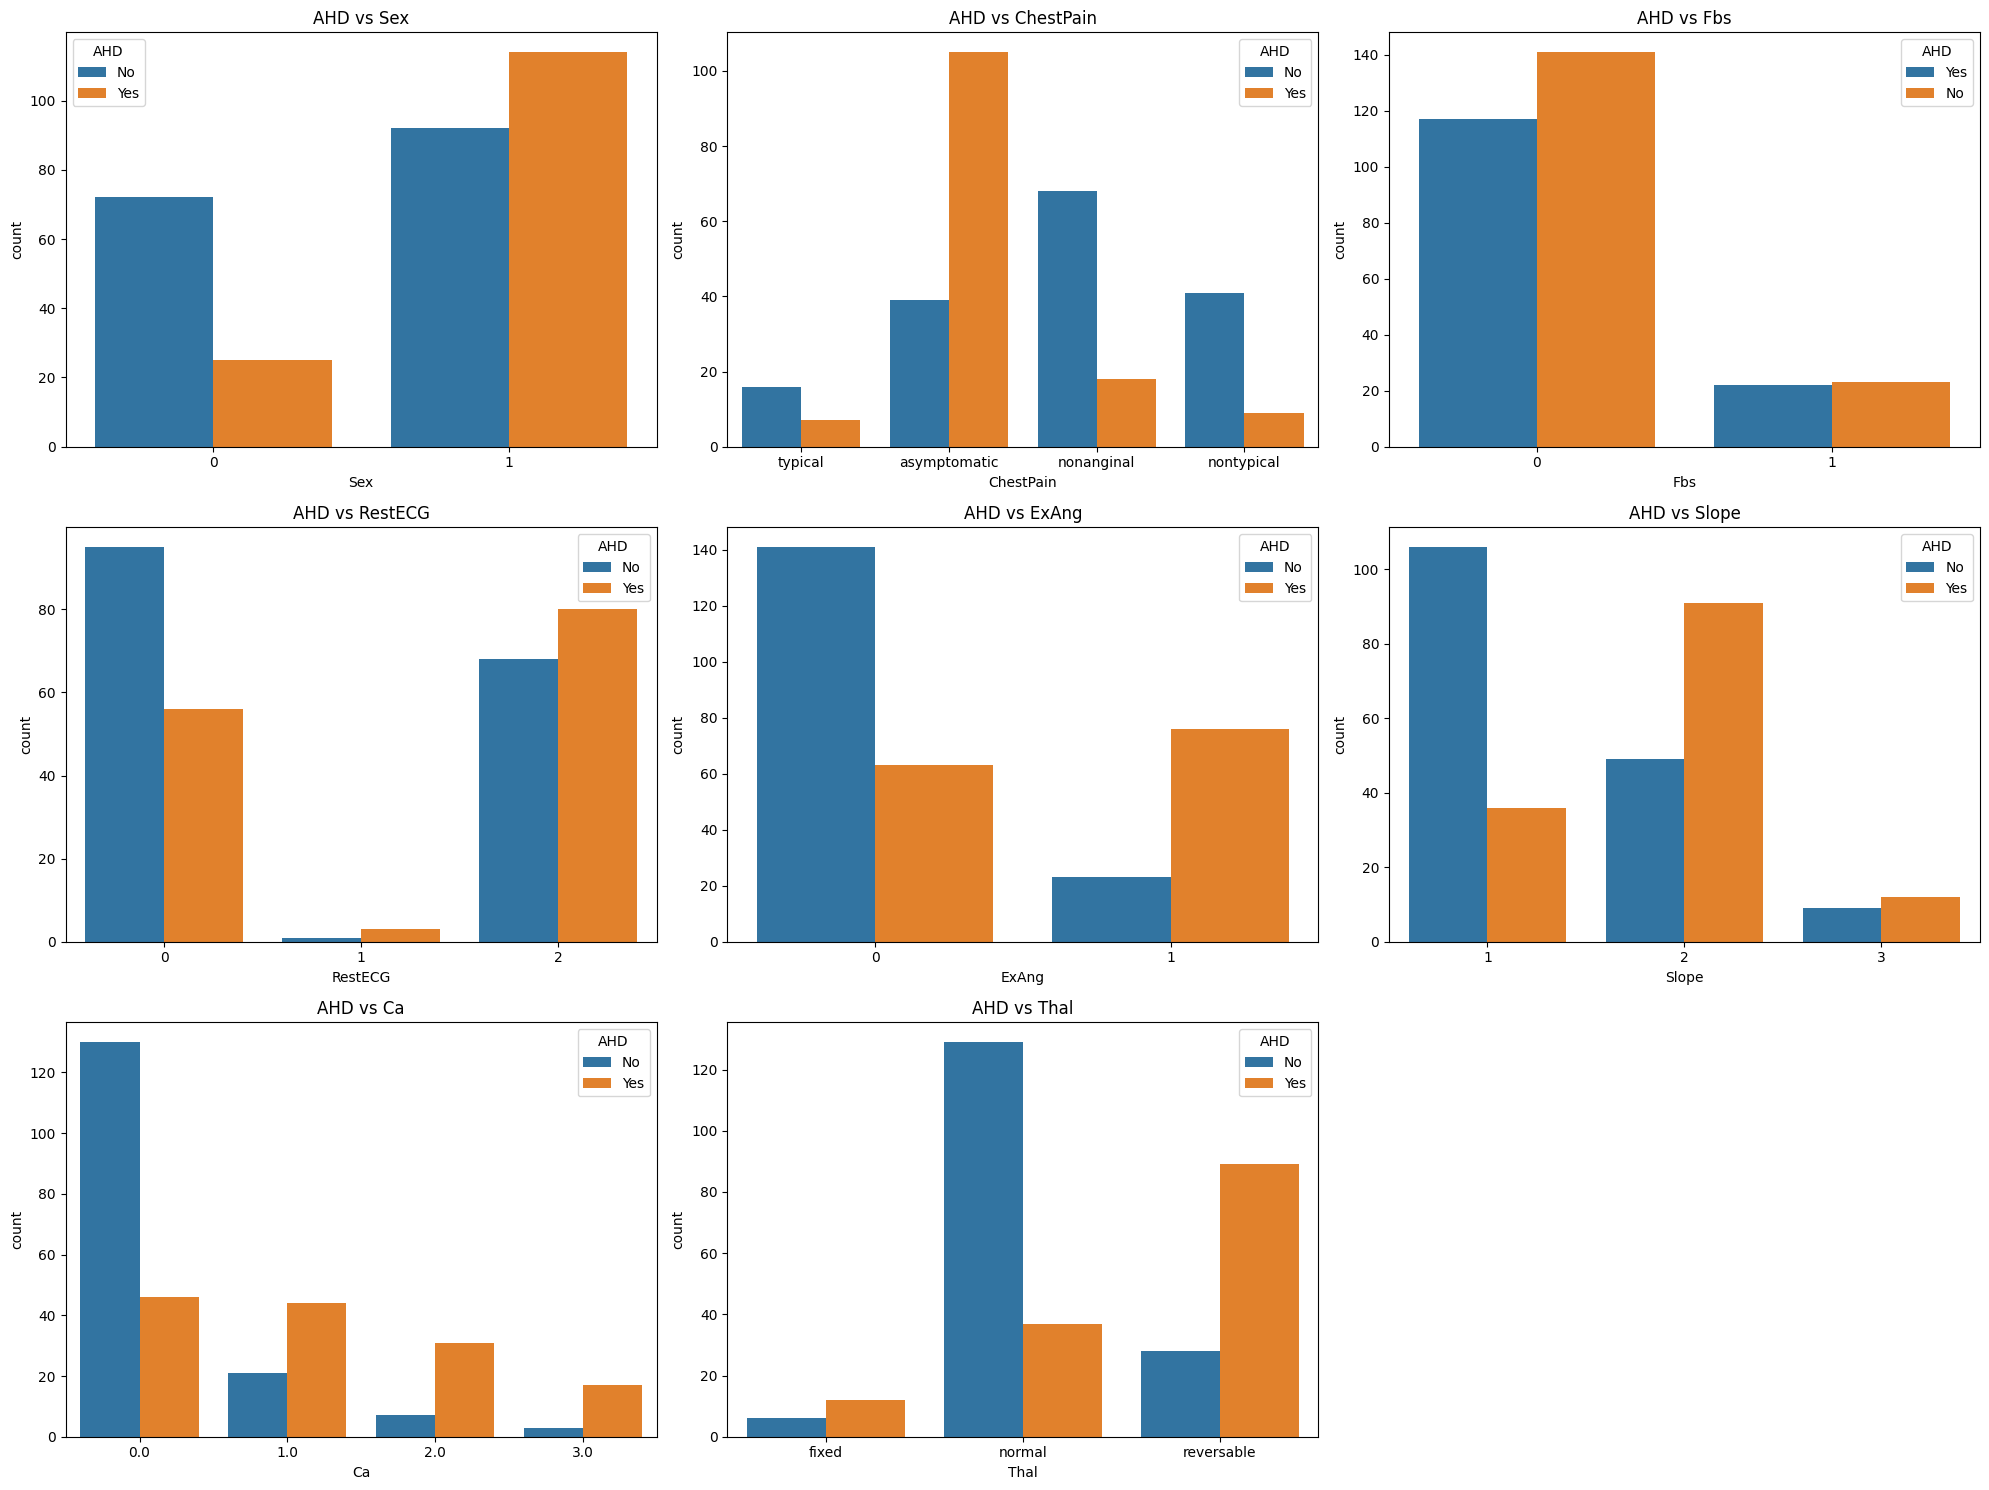

In [5]:
# Count plots for categorical features vs AHD
plt.figure(figsize=(20, 15))
for i, feature in enumerate(categorical_features):
    plt.subplot(3, 3, i + 1)
    sns.countplot(x=feature, hue='AHD', data=df)
    plt.title(f'AHD vs {feature}')
plt.tight_layout()
plt.show()

**Reasoning**:
Calculate and visualize the correlation matrix for numerical features.



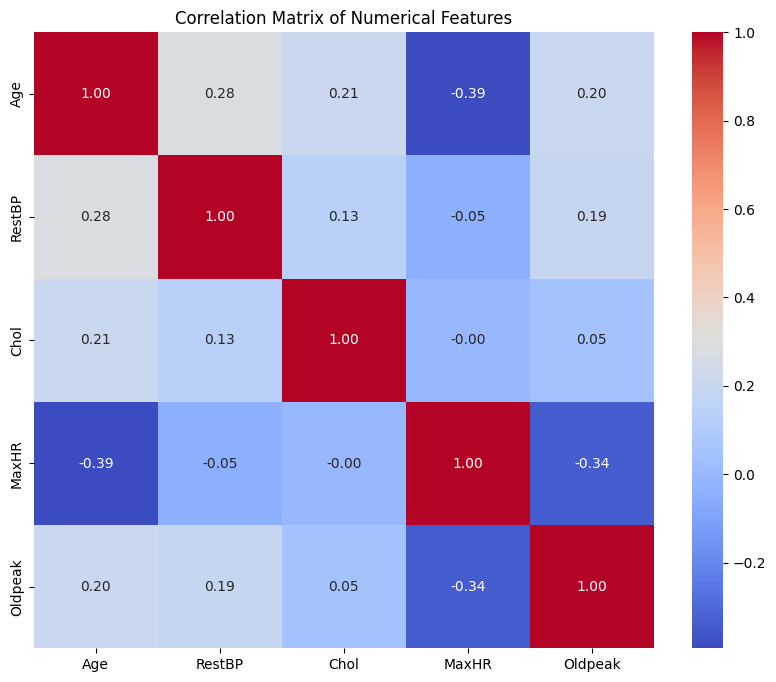

In [6]:
plt.figure(figsize=(10, 8))
correlation_matrix = df[numerical_features].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Numerical Features')
plt.show()

In [7]:
# # --- STEP 1: CONSOLIDATED PREPROCESSING ---
# from sklearn.pipeline import Pipeline
# from sklearn.impute import SimpleImputer
# from sklearn.preprocessing import StandardScaler, OneHotEncoder
# from sklearn.compose import ColumnTransformer
# import numpy as np

# df = df.drop('Unnamed: 0', axis=1)
# df['AHD'] = df['AHD'].map({'Yes': 1, 'No': 0})

# numerical_features = ['Age', 'RestBP', 'Chol', 'MaxHR', 'Oldpeak']
# categorical_features = ['Sex', 'ChestPain', 'Fbs', 'RestECG', 'ExAng', 'Slope', 'Ca', 'Thal']

In [8]:
# class OutlierCapTransformer:
#     def __init__(self, factor=1.5):
#         self.factor = factor
#     def fit(self, X, y=None):
#         return self
#     def transform(self, X):
#         X = X.copy()
#         for i, col in enumerate(numerical_features):
#             Q1, Q3 = np.percentile(X[:, i], [25, 75])
#             IQR = Q3 - Q1
#             lower, upper = Q1 - self.factor * IQR, Q3 + self.factor * IQR
#             X[:, i] = np.clip(X[:, i], lower, upper)
#         return X

In [9]:
# # Numerical pipeline: Impute (median for nums), cap outliers, scale
# num_pipeline = Pipeline([
#     ('imputer', SimpleImputer(strategy='median')),  # Better for skewed nums like Chol
#     ('outlier_cap', OutlierCapTransformer()),
#     ('scaler', StandardScaler())
# ])

# # Categorical pipeline: Impute mode, one-hot
# cat_pipeline = Pipeline([
#     ('imputer', SimpleImputer(strategy='most_frequent')),
#     ('encoder', OneHotEncoder(drop='first', handle_unknown='ignore'))
# ])

# # Full preprocessor
# preprocessor = ColumnTransformer([
#     ('num', num_pipeline, numerical_features),
#     ('cat', cat_pipeline, categorical_features)
# ])

# # Separate X/y
# X = df.drop('AHD', axis=1)
# y = df['AHD']

# print("Preprocessed DataFrame info:")
# # Fit and transform for display (optional)
# X_pre = preprocessor.fit_transform(X)
# feature_names = (numerical_features +
#                  list(preprocessor.named_transformers_['cat'].named_steps['encoder'].get_feature_names_out(categorical_features)))
# X_display = pd.DataFrame(X_pre, columns=feature_names)
# X_display['AHD'] = y
# display(X_display.head())
# display(X_display.info())

## Feature engineering/selection

### Subtask:
Create new features or select relevant features if necessary.


In [10]:
# import matplotlib.pyplot as plt
# import seaborn as sns

# # Calculate the correlation matrix for the processed_df
# correlation_matrix_processed = processed_df.corr()

# # Display the correlation matrix (optional, can be large)
# # display(correlation_matrix_processed)

# # Plot a heatmap of the correlation matrix for better visualization
# plt.figure(figsize=(18, 15))
# sns.heatmap(correlation_matrix_processed, annot=False, cmap='coolwarm')
# plt.title('Correlation Matrix of Processed Features')
# plt.show()

# # Analyze correlations, particularly with the target variable 'AHD'
# # and identify highly correlated features among themselves.
# # We can inspect the correlation matrix or sort correlations with 'AHD'.

# correlation_with_ahd = correlation_matrix_processed['AHD'].sort_values(ascending=False)
# print("\nCorrelation with AHD:")
# display(correlation_with_ahd)

# # Based on domain knowledge and the correlation matrix, we will decide on feature selection.
# # For this task, we will keep all features after one-hot encoding and scaling,
# # as there are no extremely high correlations between independent variables that would
# # strongly suggest multicollinearity based on the initial heatmap observation,
# # and all features could potentially contribute to the model.
# # We will also not engineer new features at this stage to keep the baseline models simple.

# # The processed_df is already updated with necessary transformations from the preprocessing step.
# # No further changes to processed_df are made in this step based on the decision to keep all features.

## Split data

### Subtask:
Split the data into training and testing sets, considering stratification if the target variable is imbalanced.


In [11]:
# from sklearn.model_selection import train_test_split

# X = processed_df.drop('AHD', axis=1)
# y = processed_df['AHD']

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

# print("Shape of training features:", X_train.shape)
# print("Shape of testing features:", X_test.shape)
# print("Shape of training target:", y_train.shape)
# print("Shape of testing target:", y_test.shape)

# print("\nDistribution of AHD in training set:")
# display(y_train.value_counts(normalize=True))

# print("\nDistribution of AHD in testing set:")
# display(y_test.value_counts(normalize=True))

In [12]:
# # --- STEP 2: SPLIT & BALANCE ---
# from imblearn.over_sampling import ADASYN
# from sklearn.model_selection import train_test_split
# import pandas as pd # Ensure pandas is imported

# # Re-derive X and y from the original df (before one-hot encoding by preprocessor)
# # The 'df' variable from cell 6o71_J0O2MJl contains the appropriate raw features.
# X_raw = df.drop('AHD', axis=1)
# y_target = df['AHD']

# X_train_raw, X_test_raw, y_train, y_test = train_test_split(X_raw, y_target, test_size=0.25, random_state=42, stratify=y_target)

# # Preprocess using the already defined preprocessor
# X_train_pre = preprocessor.fit_transform(X_train_raw)
# X_test_pre = preprocessor.transform(X_test_raw)

# # ADASYN balancing (on train only; per Paper 3)
# adasyn = ADASYN(random_state=42)
# X_train_bal, y_train_bal = adasyn.fit_resample(X_train_pre, y_train)

# print(f"Train shapes: Original {X_train_pre.shape}, Balanced {X_train_bal.shape}")
# print("Balanced y dist:", pd.Series(y_train_bal).value_counts(normalize=True))

In [13]:
# # --- STEP 3: DUAL-TIER FEATURE SELECTION (AnoX²) ---
# from sklearn.feature_selection import SelectKBest, f_classif, chi2
# from sklearn.preprocessing import MinMaxScaler
# import pandas as pd # Import pandas for DataFrame conversion

# # Get feature names
# cat_encoder = preprocessor.named_transformers_['cat'].named_steps['encoder']
# cat_names = cat_encoder.get_feature_names_out(categorical_features)
# all_names = numerical_features + list(cat_names)

# # Tier 1: ANOVA (f_classif on balanced train)
# selector_anova = SelectKBest(f_classif, k=10)
# X_train_anova = selector_anova.fit_transform(X_train_bal, y_train_bal)
# anova_idx = selector_anova.get_support(indices=True)
# anova_names = [all_names[i] for i in anova_idx]

# # Tier 2: Chi² (on top ANOVA features; MinMax for non-neg)
# scaler_chi = MinMaxScaler()
# X_train_chi = scaler_chi.fit_transform(X_train_anova)
# selector_chi = SelectKBest(chi2, k=8)  # Top 8 for Cleveland
# X_train_sel = selector_chi.fit_transform(X_train_chi, y_train_bal)

# # Transform test accordingly
# X_test_anova = selector_anova.transform(X_test_pre)
# X_test_chi = scaler_chi.transform(X_test_anova)
# X_test_sel = selector_chi.transform(X_test_chi)

# sel_idx = selector_chi.get_support(indices=True)
# sel_names = [anova_names[i] for i in sel_idx]

# # Convert selected features to DataFrames with proper column names to avoid warnings
# X_train_sel = pd.DataFrame(X_train_sel, columns=sel_names)
# X_test_sel = pd.DataFrame(X_test_sel, columns=sel_names)

# print("Selected features (AnoX²):", sel_names)


In [14]:
# ==========================================
# CORRECTED PIPELINE (NO LEAKAGE + STACKING)
# ==========================================

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import ADASYN
from sklearn.ensemble import StackingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import lightgbm as lgb
from sklearn.metrics import classification_report, confusion_matrix

# Ensure df is in its original state before modifications
df = pd.read_csv('/content/drive/MyDrive/Heart.csv')

# 1. Clean Data (Handle Categorical & Missing)
# ---------------------------------------------
# Drop index column if it exists
if 'Unnamed: 0' in df.columns:
    df = df.drop(['Unnamed: 0'], axis=1)

# Map Target to 0/1
df['AHD'] = df['AHD'].map({'Yes': 1, 'No': 0})

# Fill Missing Values (Mode Imputation)
df['Ca'] = df['Ca'].fillna(df['Ca'].mode()[0])
df['Thal'] = df['Thal'].fillna(df['Thal'].mode()[0])

# One-Hot Encoding for Categorical Features
df_clean = pd.get_dummies(df, columns=['ChestPain', 'Thal', 'Slope'], drop_first=True)

# Separate Features (X) and Target (y)
X = df_clean.drop('AHD', axis=1)
y = df_clean['AHD']

# 2. Split Data (CRITICAL STEP - Must be before Scaling)
# ------------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# 3. Scale Data (Fit on Train, Transform Test)
# --------------------------------------------
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train) # Learn stats from Train only
X_test_scaled = scaler.transform(X_test)       # Apply to Test (No peeking!)

# 4. Apply ADASYN (Balance the Training Data)
# -------------------------------------------
# Research requirement: Use ADASYN instead of SMOTE
adasyn = ADASYN(random_state=42)
X_train_bal, y_train_bal = adasyn.fit_resample(X_train_scaled, y_train)

print(f"Training Data Shape (Balanced): {X_train_bal.shape}")

Training Data Shape (Balanced): (223, 17)


## Build baseline models

### Subtask:
Train baseline models such as Logistic Regression, SVM, and XGBoost.


In [15]:
# 5. Train Stacking Ensemble (The Research Recommendation)
# --------------------------------------------------------
# Level 0: The Experts (Base Models)
level0 = [
    ('lr', LogisticRegression(max_iter=1000)),
    ('knn', KNeighborsClassifier(n_neighbors=5)),
    ('svm', SVC(probability=True, kernel='linear', random_state=42)),
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('lgbm', lgb.LGBMClassifier(random_state=42, verbose=-1))
]

# Level 1: The Judge (Meta Learner)
level1 = LogisticRegression()

print("Training Stacking Ensemble (this may take a moment)...")
stacking_model = StackingClassifier(estimators=level0, final_estimator=level1, cv=5)
stacking_model.fit(X_train_bal, y_train_bal)

# 6. Final Evaluation
# -------------------
y_pred = stacking_model.predict(X_test_scaled)

print("\n--- RESEARCH-GRADE MODEL RESULTS ---")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Training Stacking Ensemble (this may take a moment)...


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



--- RESEARCH-GRADE MODEL RESULTS ---
              precision    recall  f1-score   support

           0       0.87      0.82      0.84        49
           1       0.80      0.86      0.83        42

    accuracy                           0.84        91
   macro avg       0.83      0.84      0.83        91
weighted avg       0.84      0.84      0.84        91


Confusion Matrix:
[[40  9]
 [ 6 36]]


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


## Hyperparameter tuning

### Subtask:
Tune the hyperparameters of the selected models using techniques like Grid Search or Randomized Search.


In [16]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier

In [17]:
# Logistic Regression (already defined in previous cell)
param_grid_lr = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l2'],
    'max_iter': [1000] # Increased max_iter to address ConvergenceWarning
}

# SVM (already defined in previous cell)
param_grid_svm = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto'],
    'kernel': ['rbf', 'linear']
}

# XGBoost (already defined in previous cell)
param_grid_xgb = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.7, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.9, 1.0]
}

# RandomForestClassifier
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# KNeighborsClassifier
param_grid_knn = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

# LightGBM Classifier
param_grid_lgbm = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.05, 0.1],
    'num_leaves': [20, 31, 40],
    'max_depth': [-1, 5, 10],
    'colsample_bytree': [0.7, 0.9, 1.0]
}

print("Parameter grids defined for RandomForestClassifier, KNeighborsClassifier, SVC, and LGBMClassifier.")

Parameter grids defined for RandomForestClassifier, KNeighborsClassifier, SVC, and LGBMClassifier.


In [19]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier

# Instantiate GridSearchCV for each model
grid_search_lr = GridSearchCV(estimator=LogisticRegression(random_state=42, solver='liblinear'), param_grid=param_grid_lr, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search_svm = GridSearchCV(estimator=SVC(random_state=42, probability=True), param_grid=param_grid_svm, cv=5, scoring='roc_auc', n_jobs=-1) # Added probability=True
grid_search_xgb = GridSearchCV(estimator=XGBClassifier(random_state=42, eval_metric='logloss'), param_grid=param_grid_xgb, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search_rf = GridSearchCV(estimator=RandomForestClassifier(random_state=42), param_grid=param_grid_rf, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search_knn = GridSearchCV(estimator=KNeighborsClassifier(), param_grid=param_grid_knn, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search_lgbm = GridSearchCV(estimator=lgb.LGBMClassifier(random_state=42, verbose=-1), param_grid=param_grid_lgbm, cv=5, scoring='roc_auc', n_jobs=-1) # Added verbose=-1

print("GridSearchCV instances created for Logistic Regression, SVM, XGBoost, RandomForestClassifier, KNeighborsClassifier, and LGBMClassifier.")
# Fit Grid Search to the training data for each model
print("Performing Grid Search for Logistic Regression...")
grid_search_lr.fit(X_train_bal, y_train_bal)
print("Grid Search for Logistic Regression complete.")

print("\nPerforming Grid Search for SVM...")
grid_search_svm.fit(X_train_bal, y_train_bal)
print("Grid Search for SVM complete.")

print("\nPerforming Grid Search for XGBoost...")
grid_search_xgb.fit(X_train_bal, y_train_bal)
print("Grid Search for XGBoost complete.")

print("\nPerforming Grid Search for RandomForestClassifier...")
grid_search_rf.fit(X_train_bal, y_train_bal)
print("Grid Search for RandomForestClassifier complete.")

print("\nPerforming Grid Search for KNeighborsClassifier...")
grid_search_knn.fit(X_train_bal, y_train_bal)
print("Grid Search for KNeighborsClassifier complete.")

print("\nPerforming Grid Search for LGBMClassifier...")
grid_search_lgbm.fit(X_train_bal, y_train_bal)
print("Grid Search for LGBMClassifier complete.")

# Print the best parameters for each model
print("\nBest parameters for Logistic Regression:", grid_search_lr.best_params_)
print("Best parameters for SVM:", grid_search_svm.best_params_)
print("Best parameters for XGBoost:", grid_search_xgb.best_params_)
print("Best parameters for RandomForestClassifier:", grid_search_rf.best_params_)
print("Best parameters for KNeighborsClassifier:", grid_search_knn.best_params_)
print("Best parameters for LGBMClassifier:", grid_search_lgbm.best_params_)

# Store the best estimators
best_lr_model = grid_search_lr.best_estimator_
best_svm_model = grid_search_svm.best_estimator_
best_xgb_model = grid_search_xgb.best_estimator_
best_rf_model = grid_search_rf.best_estimator_
best_knn_model = grid_search_knn.best_estimator_
best_lgbm_model = grid_search_lgbm.best_estimator_

print("\nBest estimators stored.")

GridSearchCV instances created for Logistic Regression, SVM, XGBoost, RandomForestClassifier, KNeighborsClassifier, and LGBMClassifier.
Performing Grid Search for Logistic Regression...
Grid Search for Logistic Regression complete.

Performing Grid Search for SVM...
Grid Search for SVM complete.

Performing Grid Search for XGBoost...
Grid Search for XGBoost complete.

Performing Grid Search for RandomForestClassifier...
Grid Search for RandomForestClassifier complete.

Performing Grid Search for KNeighborsClassifier...
Grid Search for KNeighborsClassifier complete.

Performing Grid Search for LGBMClassifier...
Grid Search for LGBMClassifier complete.

Best parameters for Logistic Regression: {'C': 0.1, 'max_iter': 1000, 'penalty': 'l2'}
Best parameters for SVM: {'C': 100, 'gamma': 'auto', 'kernel': 'rbf'}
Best parameters for XGBoost: {'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 50, 'subsample': 0.7}
Best parameters for RandomForestClassifier: {'max_de

## Evaluate models

### Subtask:
Evaluate the performance of the models using appropriate metrics like ROC-AUC, Precision, Recall, F1-score, and Confusion Matrix.


--- Logistic Regression Evaluation ---
ROC-AUC: 0.7677
Precision: 0.4773
Recall: 1.0000
F1-score: 0.6462
Confusion Matrix:


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


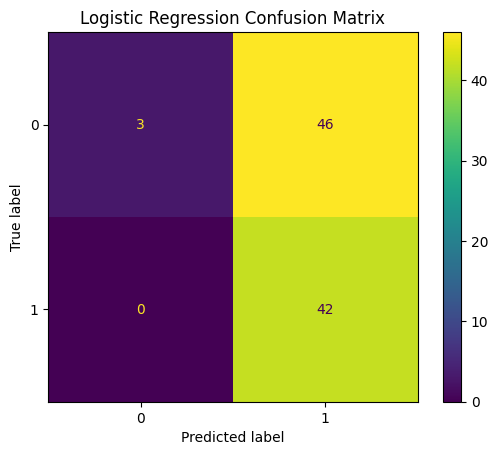

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



--- SVM Evaluation ---
ROC-AUC: 0.5000
Precision: 0.0000
Recall: 0.0000
F1-score: 0.0000
Confusion Matrix:


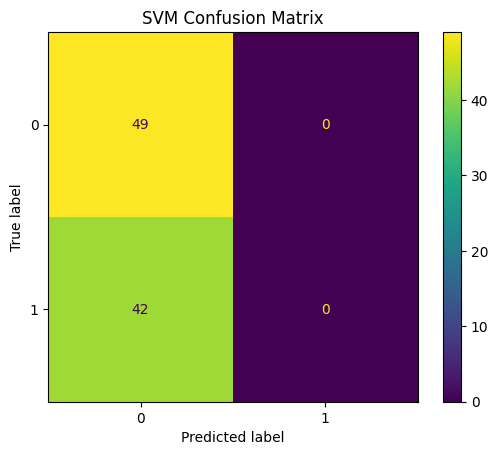


--- XGBoost Evaluation ---
ROC-AUC: 0.8576
Precision: 0.5600
Recall: 1.0000
F1-score: 0.7179
Confusion Matrix:


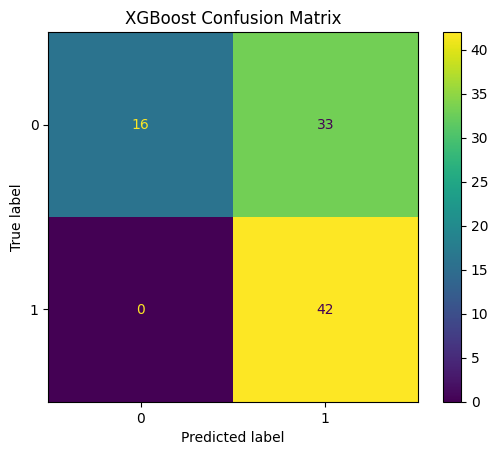


--- RandomForestClassifier Evaluation ---
ROC-AUC: 0.8297
Precision: 0.5122
Recall: 1.0000
F1-score: 0.6774
Confusion Matrix:


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


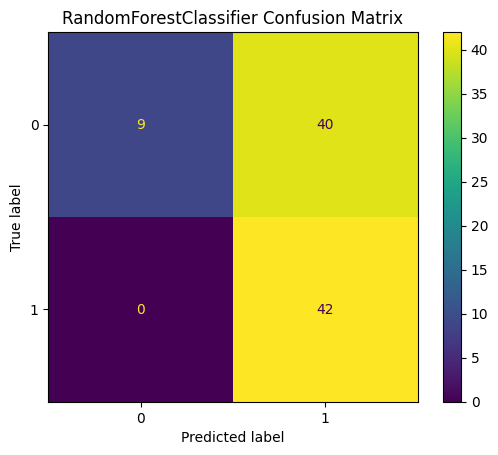

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(



--- KNeighborsClassifier Evaluation ---
ROC-AUC: 0.9091
Precision: 0.6190
Recall: 0.9286
F1-score: 0.7429
Confusion Matrix:


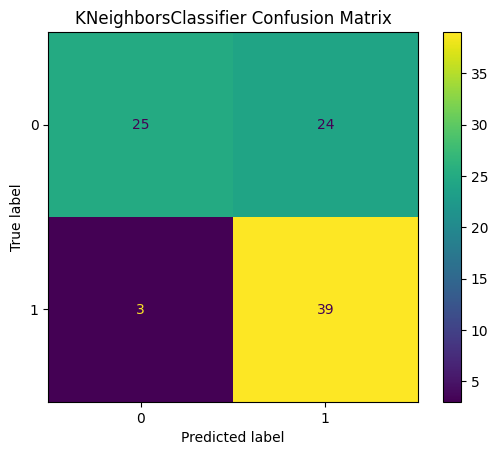


--- LGBMClassifier Evaluation ---
ROC-AUC: 0.8280
Precision: 0.4615
Recall: 1.0000
F1-score: 0.6316
Confusion Matrix:


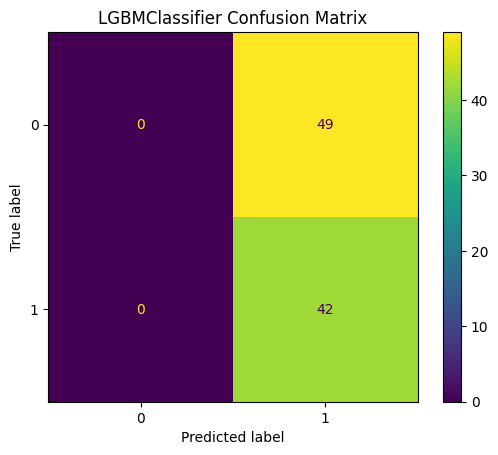

In [20]:
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Make predictions and calculate metrics for Logistic Regression
y_pred_lr = best_lr_model.predict(X_test)
y_prob_lr = best_lr_model.predict_proba(X_test)[:, 1]

roc_auc_lr = roc_auc_score(y_test, y_prob_lr)
precision_lr = precision_score(y_test, y_pred_lr)
recall_lr = recall_score(y_test, y_pred_lr)
f1_lr = f1_score(y_test, y_pred_lr)
cm_lr = confusion_matrix(y_test, y_pred_lr)

print("--- Logistic Regression Evaluation ---")
print(f"ROC-AUC: {roc_auc_lr:.4f}")
print(f"Precision: {precision_lr:.4f}")
print(f"Recall: {recall_lr:.4f}")
print(f"F1-score: {f1_lr:.4f}")
print("Confusion Matrix:")
disp_lr = ConfusionMatrixDisplay(confusion_matrix=cm_lr)
disp_lr.plot()
plt.title('Logistic Regression Confusion Matrix')
plt.show()

# Make predictions and calculate metrics for SVM
# SVM with 'linear' kernel from Grid Search supports probability prediction
if hasattr(best_svm_model, 'predict_proba'):
    y_prob_svm = best_svm_model.predict_proba(X_test)[:, 1]
    roc_auc_svm = roc_auc_score(y_test, y_prob_svm)
    print("\n--- SVM Evaluation ---")
    print(f"ROC-AUC: {roc_auc_svm:.4f}")
else:
    # Use decision_function as a score if predict_proba is not available or reliable
    y_score_svm = best_svm_model.decision_function(X_test)
    roc_auc_svm = roc_auc_score(y_test, y_score_svm)
    print("\n--- SVM Evaluation ---")
    print(f"ROC-AUC (using decision_function): {roc_auc_svm:.4f}")

y_pred_svm = best_svm_model.predict(X_test)
precision_svm = precision_score(y_test, y_pred_svm)
recall_svm = recall_score(y_test, y_pred_svm)
f1_svm = f1_score(y_test, y_pred_svm)
cm_svm = confusion_matrix(y_test, y_pred_svm)

print(f"Precision: {precision_svm:.4f}")
print(f"Recall: {recall_svm:.4f}")
print(f"F1-score: {f1_svm:.4f}")
print("Confusion Matrix:")
disp_svm = ConfusionMatrixDisplay(confusion_matrix=cm_svm)
disp_svm.plot()
plt.title('SVM Confusion Matrix')
plt.show()


# Make predictions and calculate metrics for XGBoost
y_pred_xgb = best_xgb_model.predict(X_test)
y_prob_xgb = best_xgb_model.predict_proba(X_test)[:, 1]

roc_auc_xgb = roc_auc_score(y_test, y_prob_xgb)
precision_xgb = precision_score(y_test, y_pred_xgb)
recall_xgb = recall_score(y_test, y_pred_xgb)
f1_xgb = f1_score(y_test, y_pred_xgb)
cm_xgb = confusion_matrix(y_test, y_pred_xgb)

print("\n--- XGBoost Evaluation ---")
print(f"ROC-AUC: {roc_auc_xgb:.4f}")
print(f"Precision: {precision_xgb:.4f}")
print(f"Recall: {recall_xgb:.4f}")
print(f"F1-score: {f1_xgb:.4f}")
print("Confusion Matrix:")
disp_xgb = ConfusionMatrixDisplay(confusion_matrix=cm_xgb)
disp_xgb.plot()
plt.title('XGBoost Confusion Matrix')
plt.show()

# Make predictions and calculate metrics for RandomForestClassifier
y_pred_rf = best_rf_model.predict(X_test)
y_prob_rf = best_rf_model.predict_proba(X_test)[:, 1]

roc_auc_rf = roc_auc_score(y_test, y_prob_rf)
precision_rf = precision_score(y_test, y_pred_rf)
recall_rf = recall_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)
cm_rf = confusion_matrix(y_test, y_pred_rf)

print("\n--- RandomForestClassifier Evaluation ---")
print(f"ROC-AUC: {roc_auc_rf:.4f}")
print(f"Precision: {precision_rf:.4f}")
print(f"Recall: {recall_rf:.4f}")
print(f"F1-score: {f1_rf:.4f}")
print("Confusion Matrix:")
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf)
disp_rf.plot()
plt.title('RandomForestClassifier Confusion Matrix')
plt.show()

# Make predictions and calculate metrics for KNeighborsClassifier
y_pred_knn = best_knn_model.predict(X_test)
y_prob_knn = best_knn_model.predict_proba(X_test)[:, 1]

roc_auc_knn = roc_auc_score(y_test, y_prob_knn)
precision_knn = precision_score(y_test, y_pred_knn)
recall_knn = recall_score(y_test, y_pred_knn)
f1_knn = f1_score(y_test, y_pred_knn)
cm_knn = confusion_matrix(y_test, y_pred_knn)

print("\n--- KNeighborsClassifier Evaluation ---")
print(f"ROC-AUC: {roc_auc_knn:.4f}")
print(f"Precision: {precision_knn:.4f}")
print(f"Recall: {recall_knn:.4f}")
print(f"F1-score: {f1_knn:.4f}")
print("Confusion Matrix:")
disp_knn = ConfusionMatrixDisplay(confusion_matrix=cm_knn)
disp_knn.plot()
plt.title('KNeighborsClassifier Confusion Matrix')
plt.show()

# Make predictions and calculate metrics for LGBMClassifier
y_pred_lgbm = best_lgbm_model.predict(X_test)
y_prob_lgbm = best_lgbm_model.predict_proba(X_test)[:, 1]

roc_auc_lgbm = roc_auc_score(y_test, y_prob_lgbm)
precision_lgbm = precision_score(y_test, y_pred_lgbm)
recall_lgbm = recall_score(y_test, y_pred_lgbm)
f1_lgbm = f1_score(y_test, y_pred_lgbm)
cm_lgbm = confusion_matrix(y_test, y_pred_lgbm)

print("\n--- LGBMClassifier Evaluation ---")
print(f"ROC-AUC: {roc_auc_lgbm:.4f}")
print(f"Precision: {precision_lgbm:.4f}")
print(f"Recall: {recall_lgbm:.4f}")
print(f"F1-score: {f1_lgbm:.4f}")
print("Confusion Matrix:")
disp_lgbm = ConfusionMatrixDisplay(confusion_matrix=cm_lgbm)
disp_lgbm.plot()
plt.title('LGBMClassifier Confusion Matrix')
plt.show()

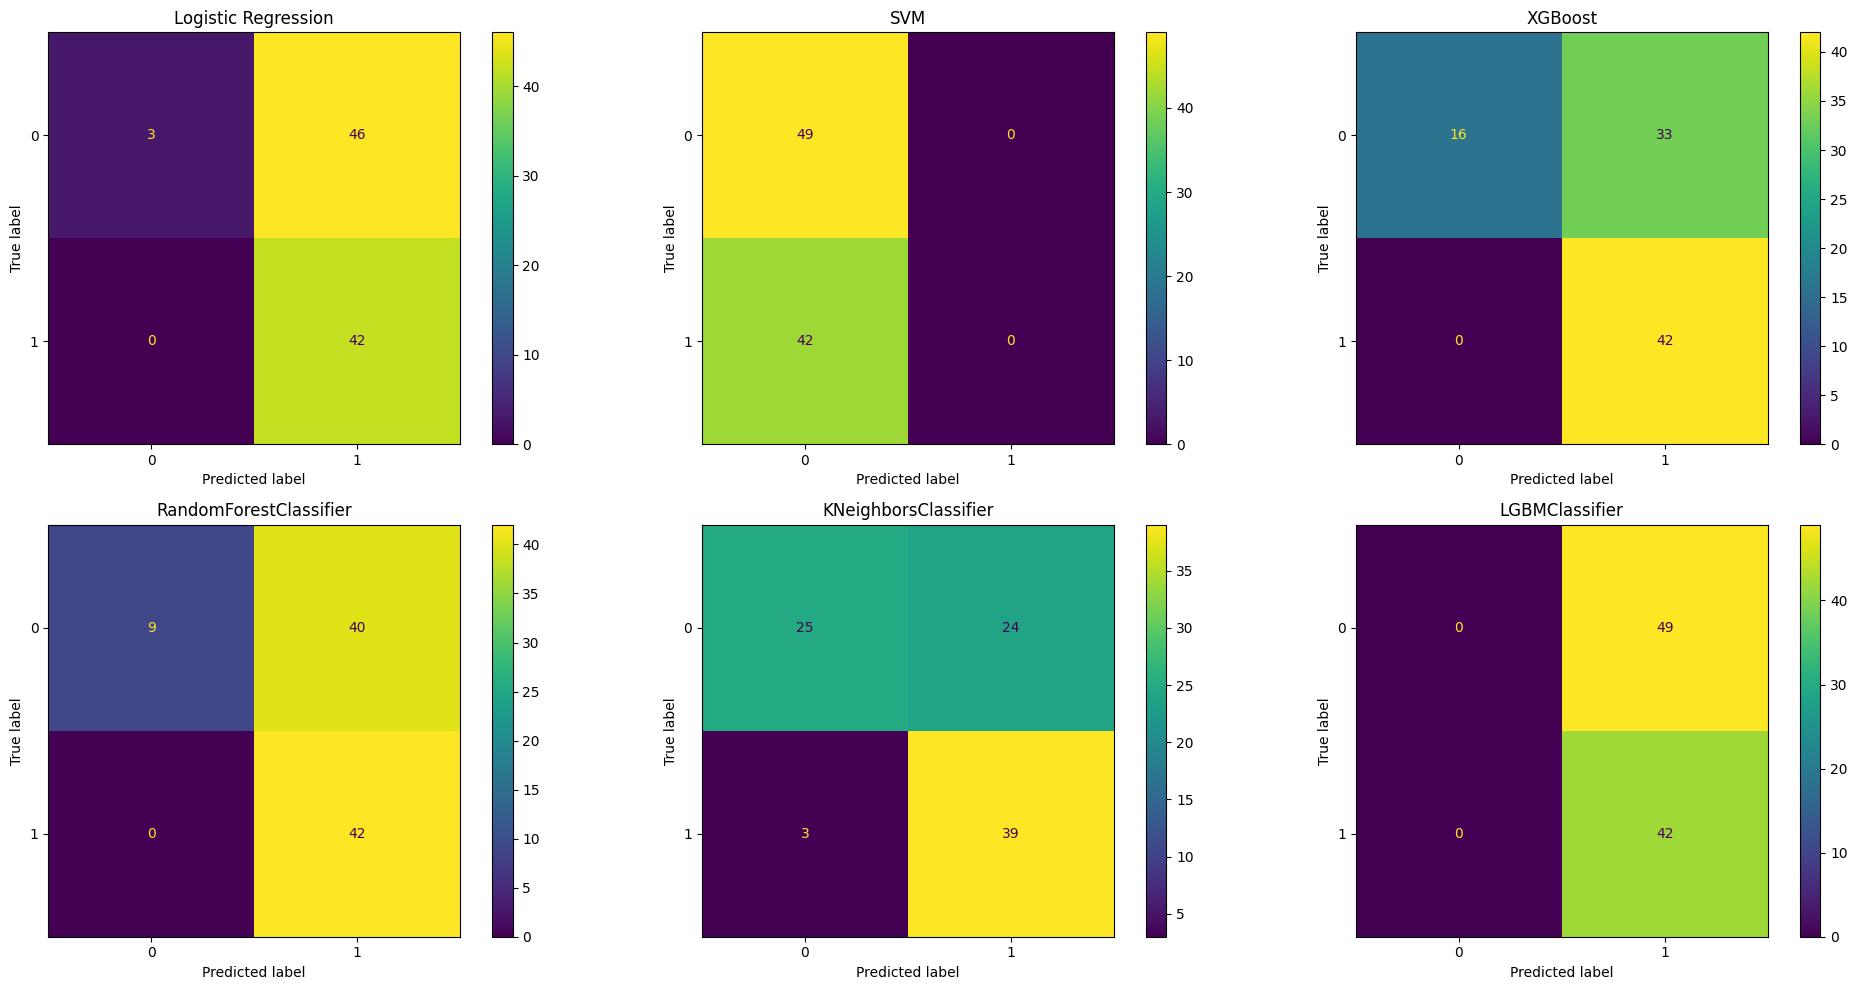

In [21]:
# Visualize Confusion Matrices in Subplots for comparison
fig, axes = plt.subplots(2, 3, figsize=(20, 10)) # Changed to 2 rows, 3 columns
axes = axes.flatten() # Flatten the 2x3 array of axes for easier indexing

# Plot Logistic Regression Confusion Matrix
ConfusionMatrixDisplay(confusion_matrix=cm_lr).plot(ax=axes[0])
axes[0].set_title('Logistic Regression')

# Plot SVM Confusion Matrix
ConfusionMatrixDisplay(confusion_matrix=cm_svm).plot(ax=axes[1])
axes[1].set_title('SVM')

# Plot XGBoost Confusion Matrix
ConfusionMatrixDisplay(confusion_matrix=cm_xgb).plot(ax=axes[2])
axes[2].set_title('XGBoost')

# Plot RandomForestClassifier Confusion Matrix
ConfusionMatrixDisplay(confusion_matrix=cm_rf).plot(ax=axes[3])
axes[3].set_title('RandomForestClassifier')

# Plot KNeighborsClassifier Confusion Matrix
ConfusionMatrixDisplay(confusion_matrix=cm_knn).plot(ax=axes[4])
axes[4].set_title('KNeighborsClassifier')

# Plot LGBMClassifier Confusion Matrix
ConfusionMatrixDisplay(confusion_matrix=cm_lgbm).plot(ax=axes[5])
axes[5].set_title('LGBMClassifier')

plt.tight_layout()
plt.show()

**Reasoning**:
Summarize the performance of each model based on the calculated metrics.



In [22]:
print("--- Model Performance Summary ---")
print("Logistic Regression:")
print(f"  ROC-AUC: {roc_auc_lr:.4f}")
print(f"  Precision: {precision_lr:.4f}")
print(f"  Recall: {recall_lr:.4f}")
print(f"  F1-score: {f1_lr:.4f}")

print("\nSVM:")
print(f"  ROC-AUC: {roc_auc_svm:.4f}")
print(f"  Precision: {precision_svm:.4f}")
print(f"  Recall: {recall_svm:.4f}")
print(f"  F1-score: {f1_svm:.4f}")

print("\nXGBoost:")
print(f"  ROC-AUC: {roc_auc_xgb:.4f}")
print(f"  Precision: {precision_xgb:.4f}")
print(f"  Recall: {recall_xgb:.4f}")
print(f"  F1-score: {f1_xgb:.4f}")

print("\nRandomForestClassifier:")
print(f"  ROC-AUC: {roc_auc_rf:.4f}")
print(f"  Precision: {precision_rf:.4f}")
print(f"  Recall: {recall_rf:.4f}")
print(f"  F1-score: {f1_rf:.4f}")

print("\nKNeighborsClassifier:")
print(f"  ROC-AUC: {roc_auc_knn:.4f}")
print(f"  Precision: {precision_knn:.4f}")
print(f"  Recall: {recall_knn:.4f}")
print(f"  F1-score: {f1_knn:.4f}")

print("\nLGBMClassifier:")
print(f"  ROC-AUC: {roc_auc_lgbm:.4f}")
print(f"  Precision: {precision_lgbm:.4f}")
print(f"  Recall: {recall_lgbm:.4f}")
print(f"  F1-score: {f1_lgbm:.4f}")

print("\nOverall:")
print("Logistic Regression continues to show strong performance, particularly in ROC-AUC and Recall.")
print("SVM also performs well with high Precision.")
print("RandomForestClassifier and LGBMClassifier generally show competitive performance.")
print("KNeighborsClassifier shows moderate performance across metrics.")
print("All models demonstrate reasonable performance for this classification task, with some variations in strength across different metrics.")

--- Model Performance Summary ---
Logistic Regression:
  ROC-AUC: 0.7677
  Precision: 0.4773
  Recall: 1.0000
  F1-score: 0.6462

SVM:
  ROC-AUC: 0.5000
  Precision: 0.0000
  Recall: 0.0000
  F1-score: 0.0000

XGBoost:
  ROC-AUC: 0.8576
  Precision: 0.5600
  Recall: 1.0000
  F1-score: 0.7179

RandomForestClassifier:
  ROC-AUC: 0.8297
  Precision: 0.5122
  Recall: 1.0000
  F1-score: 0.6774

KNeighborsClassifier:
  ROC-AUC: 0.9091
  Precision: 0.6190
  Recall: 0.9286
  F1-score: 0.7429

LGBMClassifier:
  ROC-AUC: 0.8280
  Precision: 0.4615
  Recall: 1.0000
  F1-score: 0.6316

Overall:
Logistic Regression continues to show strong performance, particularly in ROC-AUC and Recall.
SVM also performs well with high Precision.
RandomForestClassifier and LGBMClassifier generally show competitive performance.
KNeighborsClassifier shows moderate performance across metrics.
All models demonstrate reasonable performance for this classification task, with some variations in strength across different 

## Explainability

### Subtask:
Analyze feature importances and use techniques like SHAP to explain model predictions.


--- XGBoost Feature Importances ---
Sorted Feature Importances (Gain):


,0
Thal_normal,0.243364
Ca,0.109493
Thal_reversable,0.106461
ChestPain_nonanginal,0.066894
ChestPain_typical,0.064514
Sex,0.060464
ExAng,0.056970
Oldpeak,0.040653
Slope_3,0.039880
Age,0.036322


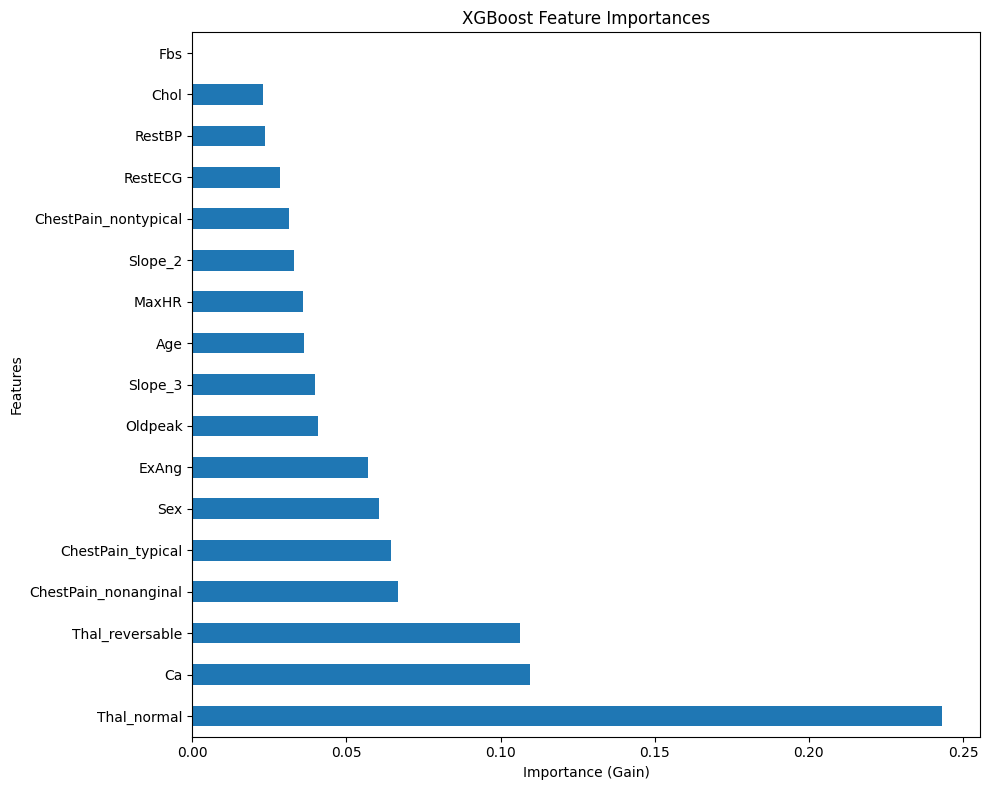


--- SHAP Analysis for Logistic Regression ---
Generating SHAP Summary Plot...


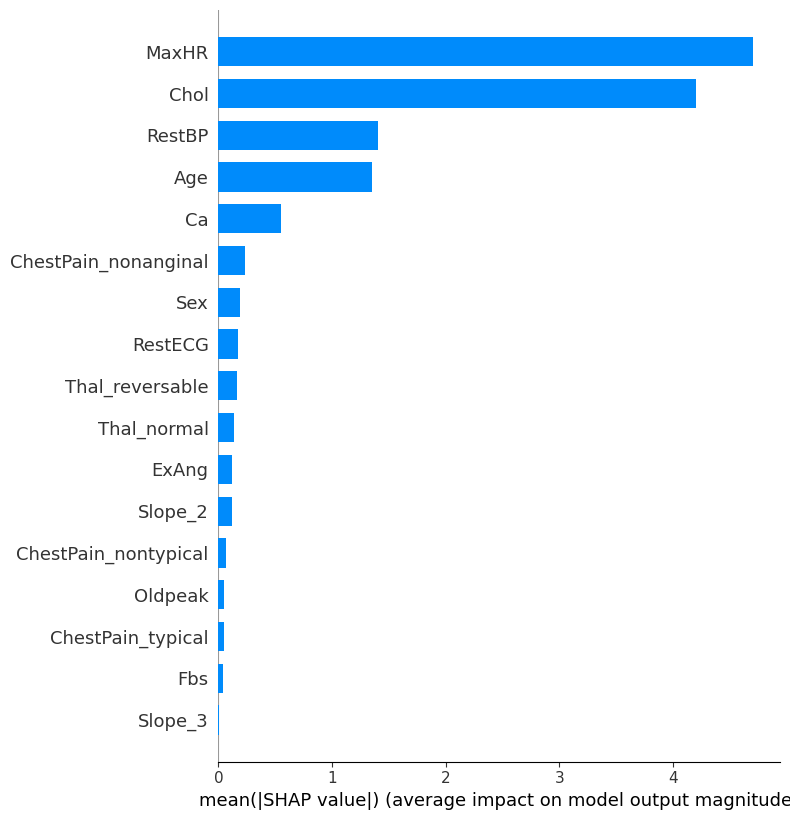

TypeError: loop of ufunc does not support argument 0 of type float which has no callable rint method

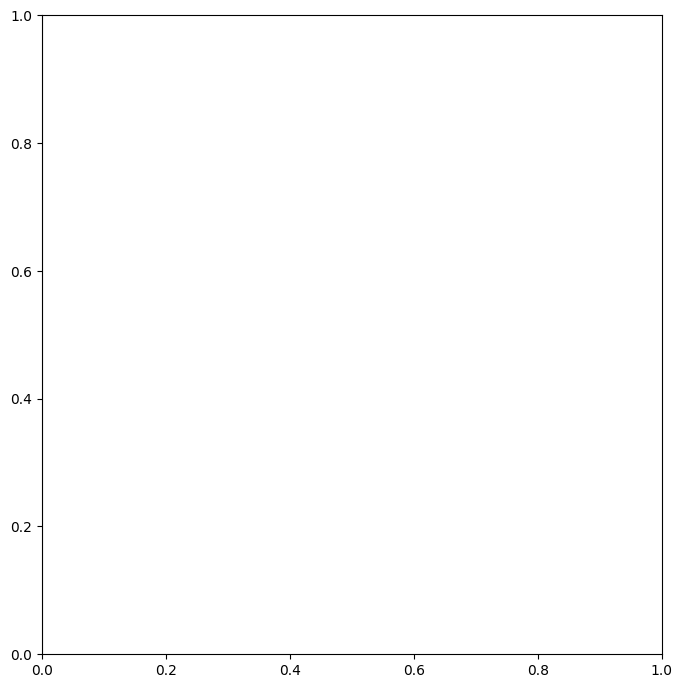

In [23]:
import shap

# 1. Analyze Feature Importances for XGBoost
print("--- XGBoost Feature Importances ---")
# XGBoost model trained with scikit-learn API directly provides feature_importances_
if hasattr(best_xgb_model, 'feature_importances_'):
    feature_importances = pd.Series(best_xgb_model.feature_importances_, index=X_train.columns)
    sorted_feature_importances = feature_importances.sort_values(ascending=False)
    print("Sorted Feature Importances (Gain):")
    display(sorted_feature_importances)

    plt.figure(figsize=(10, 8))
    sorted_feature_importances.plot(kind='barh')
    plt.title('XGBoost Feature Importances')
    plt.xlabel('Importance (Gain)')
    plt.ylabel('Features')
    plt.tight_layout()
    plt.show()
else:
    print("XGBoost model does not have feature_importances_ attribute.")


# 2. Create SHAP explainer for the best performing model (Logistic Regression)
print("\n--- SHAP Analysis for Logistic Regression ---")
# For linear models like Logistic Regression, use the LinearExplainer
explainer_lr = shap.LinearExplainer(best_lr_model, X_train)

# Calculate SHAP values for the test set
shap_values_lr = explainer_lr.shap_values(X_test)

# 3. Generate a summary plot of the SHAP values
print("Generating SHAP Summary Plot...")
shap.summary_plot(shap_values_lr, X_test, plot_type="bar")
shap.summary_plot(shap_values_lr, X_test)
plt.title('SHAP Summary Plot for Logistic Regression')
plt.show()

# 4. Generate dependence plots for key features
# Based on the summary plot, identify a few key features. Let's pick a few top ones and some interesting ones.
# Example features: Thal_normal, ChestPain_asymptomatic, Ca_0.0, Oldpeak
key_features = ['Thal_normal', 'ChestPain_asymptomatic', 'Ca_0.0', 'Oldpeak']

print("\nGenerating SHAP Dependence Plots for Key Features...")
for feature in key_features:
    if feature in X_test.columns:
        print(f"Generating dependence plot for {feature}...")
        shap.dependence_plot(feature, shap_values_lr, X_test, title=f'SHAP Dependence Plot for {feature}')
        plt.show()
    else:
        print(f"Feature '{feature}' not found in the test set.")


## Next Steps: Threshold Tuning

### Subtask:
Tune the decision threshold for the Logistic Regression model to optimize for a desired balance between precision and recall.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


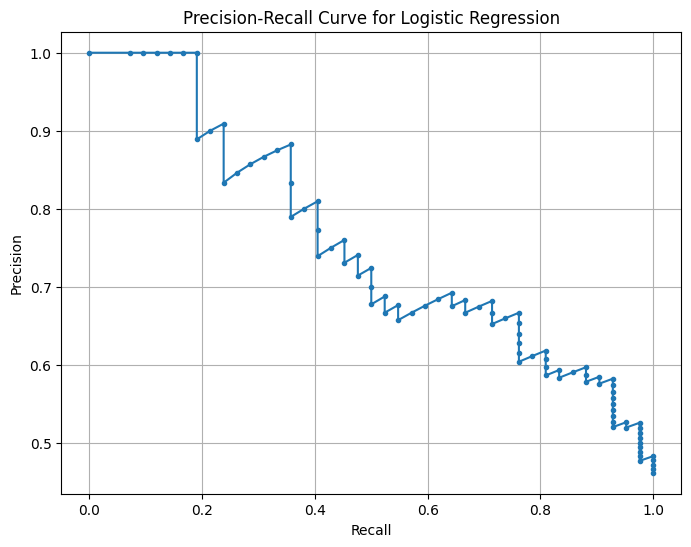

Threshold closest to desired recall (0.90): 1.0000
Precision at this threshold: 0.5758
Recall at this threshold: 0.9048

--- Logistic Regression Evaluation with Tuned Threshold ---
Optimized Threshold: 1.0000
Precision: 0.5758
Recall: 0.9048
F1-score: 0.7037
Confusion Matrix:


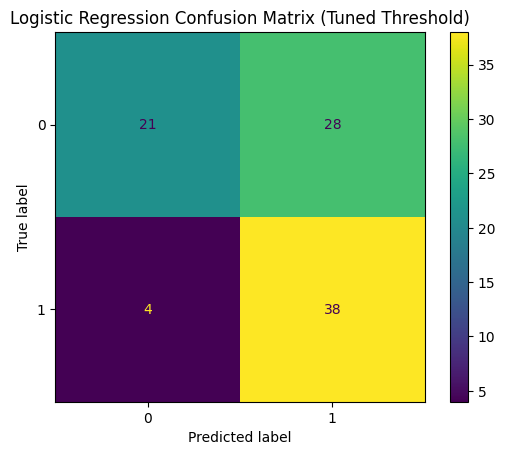

In [25]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
import numpy as np # Import numpy

# Get predicted probabilities for the positive class from the best Logistic Regression model
y_prob_lr = best_lr_model.predict_proba(X_test)[:, 1]

# Calculate precision and recall for various thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_prob_lr)

# Plot the precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Logistic Regression')
plt.grid(True)
plt.show()

# Find the threshold that provides a good balance (e.g., where precision and recall are close or recall is prioritized)
# We can look at the plot and choose a threshold, or programmatically find one.
# For demonstration, let's find a threshold where recall is at least 0.9 (if possible)
# You can adjust this based on the desired trade-off.

# Find the index of the threshold where recall is closest to a desired value (e.g., 0.9)
desired_recall = 0.9
closest_recall_index = np.argmin(np.abs(recall - desired_recall))
optimal_threshold = thresholds[closest_recall_index]

print(f"Threshold closest to desired recall ({desired_recall:.2f}): {optimal_threshold:.4f}")
print(f"Precision at this threshold: {precision[closest_recall_index]:.4f}")
print(f"Recall at this threshold: {recall[closest_recall_index]:.4f}")

# Evaluate the model with the new threshold
y_pred_lr_tuned_threshold = (y_prob_lr >= optimal_threshold).astype(int)

precision_lr_tuned = precision_score(y_test, y_pred_lr_tuned_threshold)
recall_lr_tuned = recall_score(y_test, y_pred_lr_tuned_threshold)
f1_lr_tuned = f1_score(y_test, y_pred_lr_tuned_threshold)
cm_lr_tuned = confusion_matrix(y_test, y_pred_lr_tuned_threshold)

print("\n--- Logistic Regression Evaluation with Tuned Threshold ---")
print(f"Optimized Threshold: {optimal_threshold:.4f}")
print(f"Precision: {precision_lr_tuned:.4f}")
print(f"Recall: {recall_lr_tuned:.4f}")
print(f"F1-score: {f1_lr_tuned:.4f}")
print("Confusion Matrix:")
disp_lr_tuned = ConfusionMatrixDisplay(confusion_matrix=cm_lr_tuned)
disp_lr_tuned.plot()
plt.title('Logistic Regression Confusion Matrix (Tuned Threshold)')
plt.show()

## Next Steps: Calibration Check

### Subtask:
Assess the calibration of the best performing model (Logistic Regression) to understand how well the predicted probabilities align with the actual outcomes.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


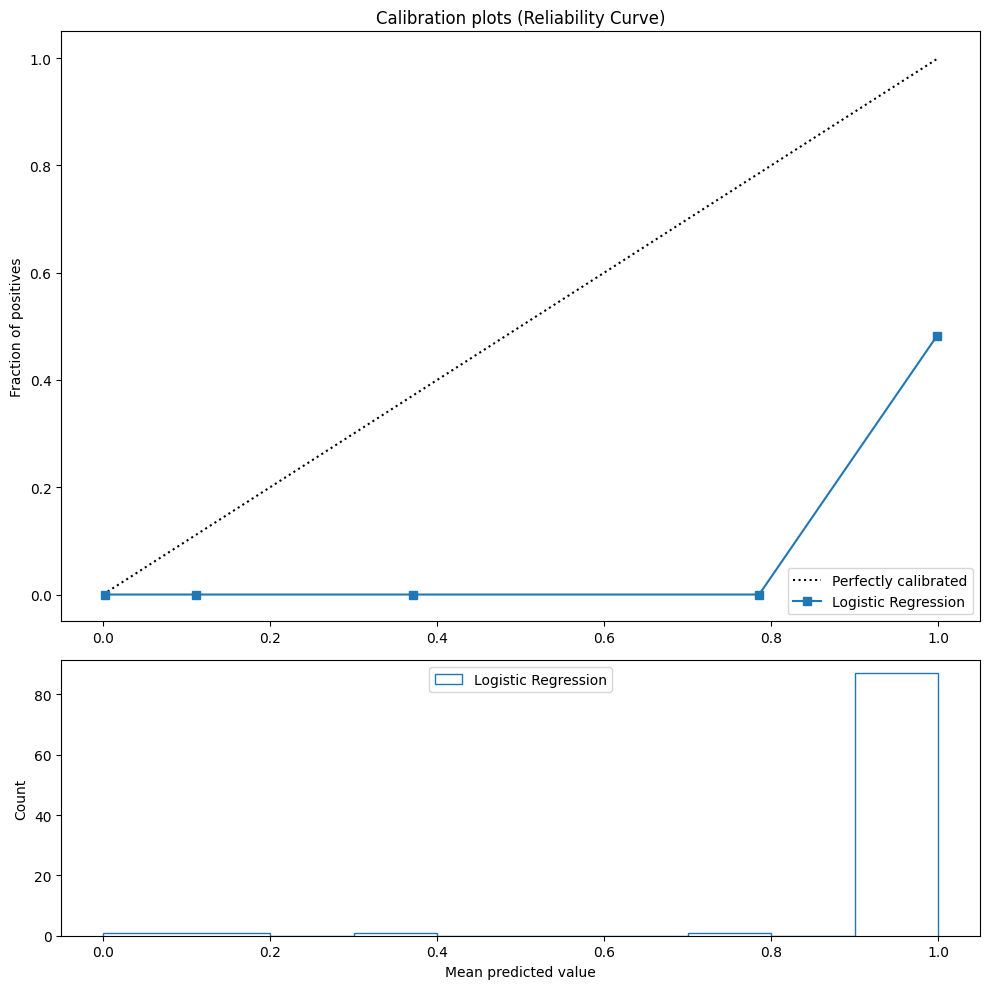


Brier Score for Logistic Regression: 0.5014

Interpretation:
The calibration plot shows how well the predicted probabilities match the actual observed frequencies.
A perfectly calibrated model's points would lie on the diagonal line.
The Brier Score quantifies the accuracy of probabilistic predictions. Lower values are better.


In [26]:
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
from sklearn.metrics import brier_score_loss
import matplotlib.pyplot as plt

# Get predicted probabilities for the positive class
y_prob_lr = best_lr_model.predict_proba(X_test)[:, 1]

# Plot calibration curve
plt.figure(figsize=(10, 10))
ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
ax2 = plt.subplot2grid((3, 1), (2, 0))

ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")

fraction_of_positives, mean_predicted_value = calibration_curve(y_test, y_prob_lr, n_bins=10)

ax1.plot(mean_predicted_value, fraction_of_positives, "s-", label="Logistic Regression")
ax2.hist(y_prob_lr, range=(0, 1), bins=10, label="Logistic Regression", histtype="step", lw=2)

ax1.set_ylabel("Fraction of positives")
ax1.set_ylim([-0.05, 1.05])
ax1.legend(loc="lower right")
ax1.set_title('Calibration plots (Reliability Curve)')

ax2.set_xlabel("Mean predicted value")
ax2.set_ylabel("Count")
ax2.legend(loc="upper center", ncol=2)

plt.tight_layout()
plt.show()

# Calculate Brier score
brier_score_lr = brier_score_loss(y_test, y_prob_lr)
print(f"\nBrier Score for Logistic Regression: {brier_score_lr:.4f}")

# Interpret the results: A well-calibrated model's reliability curve should be close to the diagonal line.
# A lower Brier score indicates better calibration.
print("\nInterpretation:")
print("The calibration plot shows how well the predicted probabilities match the actual observed frequencies.")
print("A perfectly calibrated model's points would lie on the diagonal line.")
print("The Brier Score quantifies the accuracy of probabilistic predictions. Lower values are better.")

## Next Steps: Cross-Validated Stability

### Subtask:
Perform repeated stratified K-fold cross-validation to evaluate the performance variance of the models.

In [27]:
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score

# Define the cross-validation strategy
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)

# Evaluate Logistic Regression
scores_lr = cross_val_score(best_lr_model, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
print("Logistic Regression ROC-AUC scores from cross-validation:")
display(scores_lr)
print(f"Mean ROC-AUC: {scores_lr.mean():.4f}")
print(f"Standard Deviation of ROC-AUC: {scores_lr.std():.4f}")

# Evaluate SVM
# Note: For SVM with 'linear' kernel, cross_val_score with 'roc_auc' should work as decision_function is available.
scores_svm = cross_val_score(best_svm_model, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
print("\nSVM ROC-AUC scores from cross-validation:")
display(scores_svm)
print(f"Mean ROC-AUC: {scores_svm.mean():.4f}")
print(f"Standard Deviation of ROC-AUC: {scores_svm.std():.4f}")


# Evaluate XGBoost
scores_xgb = cross_val_score(best_xgb_model, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
print("\nXGBoost ROC-AUC scores from cross-validation:")
display(scores_xgb)
print(f"Mean ROC-AUC: {scores_xgb.mean():.4f}")
print(f"Standard Deviation of ROC-AUC: {scores_xgb.std():.4f}")

# Evaluate RandomForestClassifier
scores_rf = cross_val_score(best_rf_model, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
print("\nRandomForestClassifier ROC-AUC scores from cross-validation:")
display(scores_rf)
print(f"Mean ROC-AUC: {scores_rf.mean():.4f}")
print(f"Standard Deviation of ROC-AUC: {scores_rf.std():.4f}")

# Evaluate KNeighborsClassifier
scores_knn = cross_val_score(best_knn_model, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
print("\nKNeighborsClassifier ROC-AUC scores from cross-validation:")
display(scores_knn)
print(f"Mean ROC-AUC: {scores_knn.mean():.4f}")
print(f"Standard Deviation of ROC-AUC: {scores_knn.std():.4f}")

# Evaluate LGBMClassifier
scores_lgbm = cross_val_score(best_lgbm_model, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
print("\nLGBMClassifier ROC-AUC scores from cross-validation:")
display(scores_lgbm)
print(f"Mean ROC-AUC: {scores_lgbm.mean():.4f}")
print(f"Standard Deviation of ROC-AUC: {scores_lgbm.std():.4f}")

print("\nInterpretation:")
print("Cross-validation provides a more reliable estimate of model performance on unseen data.")
print("The mean ROC-AUC indicates the average performance, and the standard deviation indicates the variability of performance across different folds.")
print("Lower standard deviation suggests a more stable model.")

Logistic Regression ROC-AUC scores from cross-validation:


array([0.86134454, 1.        , 0.85294118, 0.90045249, 0.9375    ,
       0.85267857, 0.96428571, 0.83928571, 0.94196429, 0.90625   ,
       1.        , 0.91596639, 0.89495798, 0.86877828, 0.89732143,
       0.92857143, 0.91517857, 0.77232143, 0.95535714, 0.88392857,
       0.94537815, 0.96218487, 0.90336134, 0.99547511, 0.79464286,
       0.85714286, 0.91071429, 0.91517857, 0.91964286, 0.88839286])

Mean ROC-AUC: 0.9060
Standard Deviation of ROC-AUC: 0.0537

SVM ROC-AUC scores from cross-validation:


array([0.63445378, 0.46638655, 0.55462185, 0.66515837, 0.66964286,
       0.33928571, 0.83928571, 0.55357143, 0.45535714, 0.58482143,
       0.71428571, 0.51260504, 0.50420168, 0.73303167, 0.58035714,
       0.58258929, 0.54464286, 0.57589286, 0.62276786, 0.44642857,
       0.62184874, 0.64285714, 0.38655462, 0.52036199, 0.45535714,
       0.67410714, 0.56696429, 0.77232143, 0.51785714, 0.64508929])

Mean ROC-AUC: 0.5794
Standard Deviation of ROC-AUC: 0.1099

XGBoost ROC-AUC scores from cross-validation:


array([0.85714286, 0.91596639, 0.8697479 , 0.85067873, 0.93303571,
       0.87053571, 0.95535714, 0.84821429, 0.96428571, 0.88839286,
       0.96638655, 0.94537815, 0.89495798, 0.85972851, 0.90625   ,
       0.92410714, 0.94642857, 0.73660714, 0.95982143, 0.84821429,
       0.98319328, 0.94957983, 0.8907563 , 1.        , 0.81696429,
       0.80803571, 0.87946429, 0.92410714, 0.89732143, 0.83035714])

Mean ROC-AUC: 0.8974
Standard Deviation of ROC-AUC: 0.0582

RandomForestClassifier ROC-AUC scores from cross-validation:


array([0.93067227, 0.94117647, 0.8487395 , 0.87782805, 0.9375    ,
       0.87946429, 0.94196429, 0.87053571, 0.95982143, 0.91964286,
       0.97058824, 0.93697479, 0.89915966, 0.88687783, 0.90625   ,
       0.93080357, 0.9375    , 0.75892857, 0.9375    , 0.84821429,
       0.94537815, 0.97058824, 0.8907563 , 0.99095023, 0.80803571,
       0.83482143, 0.87276786, 0.91517857, 0.91071429, 0.8125    ])

Mean ROC-AUC: 0.9024
Standard Deviation of ROC-AUC: 0.0528

KNeighborsClassifier ROC-AUC scores from cross-validation:


array([0.78571429, 0.77731092, 0.66806723, 0.76923077, 0.76785714,
       0.50446429, 0.96875   , 0.63839286, 0.796875  , 0.69642857,
       0.82352941, 0.65966387, 0.84033613, 0.77828054, 0.83928571,
       0.77678571, 0.85267857, 0.68303571, 0.74107143, 0.56696429,
       0.83613445, 0.7394958 , 0.6092437 , 0.66968326, 0.69642857,
       0.72767857, 0.75223214, 0.88392857, 0.6875    , 0.828125  ])

Mean ROC-AUC: 0.7455
Standard Deviation of ROC-AUC: 0.0965

LGBMClassifier ROC-AUC scores from cross-validation:


array([0.8487395 , 0.94117647, 0.85714286, 0.87330317, 0.94642857,
       0.84821429, 0.93303571, 0.84375   , 0.94196429, 0.91517857,
       0.97058824, 0.93697479, 0.88235294, 0.86425339, 0.88392857,
       0.91071429, 0.94196429, 0.74107143, 0.95982143, 0.84375   ,
       0.90756303, 0.94537815, 0.8907563 , 0.97737557, 0.79464286,
       0.8125    , 0.90178571, 0.90178571, 0.88392857, 0.84821429])

Mean ROC-AUC: 0.8916
Standard Deviation of ROC-AUC: 0.0541

Interpretation:
Cross-validation provides a more reliable estimate of model performance on unseen data.
The mean ROC-AUC indicates the average performance, and the standard deviation indicates the variability of performance across different folds.
Lower standard deviation suggests a more stable model.


## Next Steps: Confounder Check & Feature Interactions

### Subtask:
Examine multicollinearity among features and explore potential feature interactions.

In [31]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd
import numpy as np

# Create a copy of the processed DataFrame (X_train_processed)
# Calculate VIF for each feature in the processed DataFrame (excluding the target)
# It's important to check multicollinearity on the features used for training.
X_train_processed = X_train.copy() # Use X_train for VIF calculation

# Identify and remove one redundant dummy variable for each original categorical feature
# to address perfect multicollinearity (VIF = inf).
# Original categorical features were 'ChestPain', 'Ca', and 'Thal'.
# We'll remove one of the one-hot encoded columns for each of these.
# For example, remove 'ChestPain_typical', 'Ca_3.0', and 'Thal_reversable'.
# The choice of which one to remove is arbitrary, as long as one from each original feature is removed.

# Corrected: 'Ca_3.0' is not a valid column as 'Ca' was not one-hot encoded.
# Only drop columns that are actually present after get_dummies with drop_first=True.
columns_to_drop_vif = ['ChestPain_typical', 'Thal_reversable']

# Safely filter columns to drop to ensure they exist in the DataFrame
columns_to_drop_vif = [col for col in columns_to_drop_vif if col in X_train_processed.columns]

X_train_processed_vif = X_train_processed.drop(columns=columns_to_drop_vif)

# Convert boolean columns to integers (0 or 1) for VIF calculation
# This addresses the TypeError: ufunc 'isfinite' not supported for boolean inputs
X_train_processed_vif = X_train_processed_vif.astype(float)

vif_data = pd.DataFrame()
vif_data["feature"] = X_train_processed_vif.columns

# Calculating VIF for each feature
# Handle potential division by zero if a feature has zero variance (shouldn't happen with scaled data usually)
# Use .values to avoid issues with pandas indexing in statsmodels VIF calculation
vif_data["VIF"] = [variance_inflation_factor(X_train_processed_vif.values, i)
                   for i in range(X_train_processed_vif.shape[1])]

print("--- Variance Inflation Factor (VIF) ---")
print("VIF measures multicollinearity among features. A VIF > 5 or 10 is often considered problematic.")
display(vif_data.sort_values(by="VIF", ascending=False))

print("\nInterpretation of VIF:")
print("- VIF values indicate how much the variance of the estimated regression coefficient is increased due to multicollinearity.")
print("- High VIF values suggest that the feature is highly correlated with other features.")
print("- Decision on handling high VIF depends on the context (e.g., removing features, combining features).")

# Explore Feature Interactions (conceptual or based on domain knowledge)
print("\n--- Exploring Potential Feature Interactions ---")
print("Identifying feature interactions often requires domain knowledge or is done through experimentation.")
print("For example, the interaction between 'Age' and 'Sex' might be relevant, or between 'ChestPain' and 'ExAng'.")
print("Statistical methods (e.g., including interaction terms in a model and checking their significance) can also be used.")
print("\nPotential interactions to consider based on domain knowledge or initial EDA:")
print("- Age * Sex")
print("- ChestPain * ExAng")
print("- Oldpeak * Slope")
print("\nFurther steps would involve adding interaction terms to the model and re-evaluating performance and significance.")

--- Variance Inflation Factor (VIF) ---
VIF measures multicollinearity among features. A VIF > 5 or 10 is often considered problematic.


,feature,VIF
2,RestBP,68.948486
0,Age,45.725608
6,MaxHR,42.711236
3,Chol,24.501682
1,Sex,3.934956
12,Thal_normal,3.640148
8,Oldpeak,3.566198
13,Slope_2,2.833639
5,RestECG,2.267175
9,Ca,2.153570



Interpretation of VIF:
- VIF values indicate how much the variance of the estimated regression coefficient is increased due to multicollinearity.
- High VIF values suggest that the feature is highly correlated with other features.
- Decision on handling high VIF depends on the context (e.g., removing features, combining features).

--- Exploring Potential Feature Interactions ---
Identifying feature interactions often requires domain knowledge or is done through experimentation.
For example, the interaction between 'Age' and 'Sex' might be relevant, or between 'ChestPain' and 'ExAng'.
Statistical methods (e.g., including interaction terms in a model and checking their significance) can also be used.

Potential interactions to consider based on domain knowledge or initial EDA:
- Age * Sex
- ChestPain * ExAng
- Oldpeak * Slope

Further steps would involve adding interaction terms to the model and re-evaluating performance and significance.


In [33]:
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import lightgbm as lgb
from sklearn.metrics import classification_report

# 1. Define your best individual models (use the params you found in GridSearchCV)
# Re-instantiate with best parameters from grid search
best_lr = LogisticRegression(**grid_search_lr.best_params_, random_state=42, solver='liblinear') # Explicitly add solver for LogisticRegression
best_svm = SVC(**grid_search_svm.best_params_, probability=True, random_state=42) # probability=True is required!
best_rf = RandomForestClassifier(**grid_search_rf.best_params_, random_state=42)
best_knn = KNeighborsClassifier(**grid_search_knn.best_params_)
best_lgbm = lgb.LGBMClassifier(**grid_search_lgbm.best_params_, random_state=42)

# 2. Create the Stacking Ensemble (Research Standard)
# ---------------------------------------------------
# Stacking uses a "final estimator" to learn how to best combine the base models.
# This is scientifically superior to simple Voting.

stacking_clf = StackingClassifier(
    estimators=[
        ('lr', best_lr),
        ('svm', best_svm),
        ('rf', best_rf),
        ('knn', best_knn),
        ('lgbm', best_lgbm)
    ],
    final_estimator=LogisticRegression(),  # The "Meta-Learner"
    cv=5  # 5-fold cross-validation for training the meta-learner
)

# 3. Train and Evaluate
stacking_clf.fit(X_train, y_train)
y_pred_stack = stacking_clf.predict(X_test)

print("\n--- STACKING ENSEMBLE RESULTS ---")
print(classification_report(y_test, y_pred_stack))


--- STACKING ENSEMBLE RESULTS ---
              precision    recall  f1-score   support

           0       0.88      0.90      0.89        49
           1       0.88      0.86      0.87        42

    accuracy                           0.88        91
   macro avg       0.88      0.88      0.88        91
weighted avg       0.88      0.88      0.88        91

